# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings

warnings.filterwarnings('ignore')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [2]:
df = pd.read_csv('/kaggle/input/pjme-hourly/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

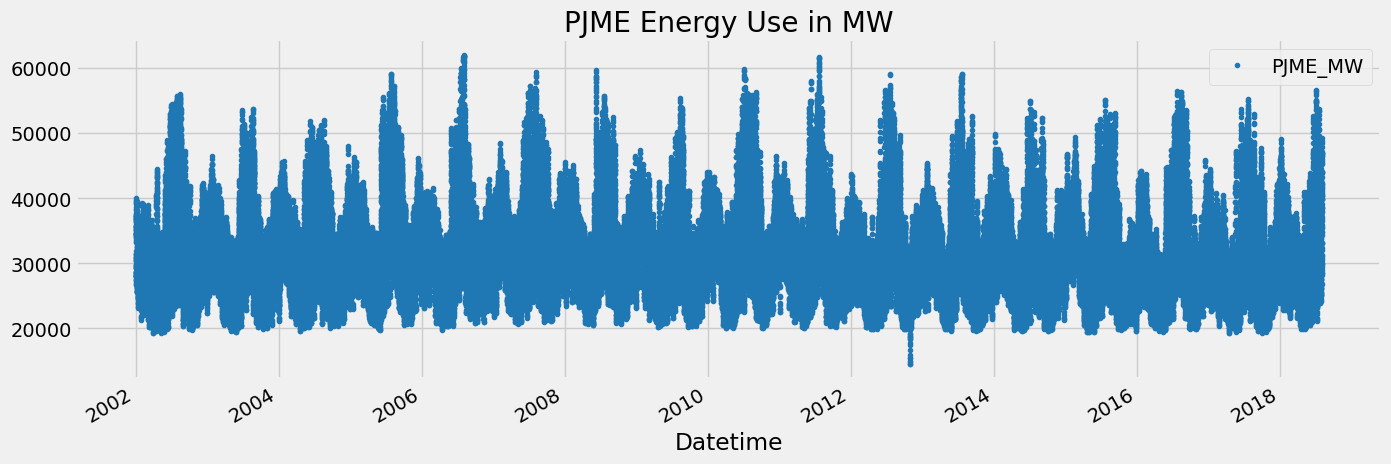

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

## plot 1 week

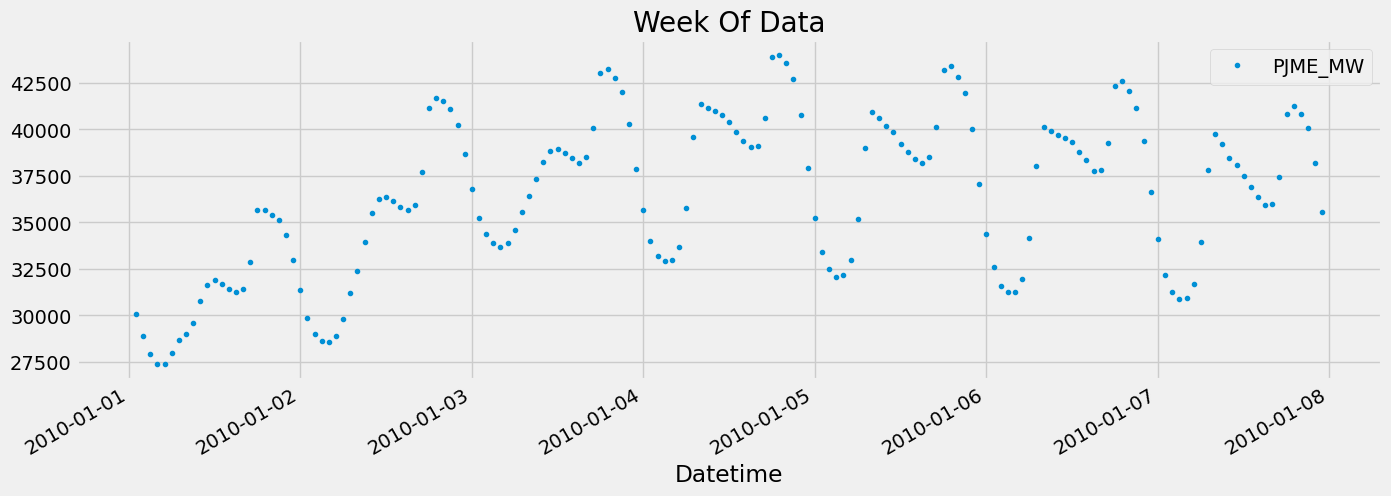

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data', style = '.')
plt.show()

# Outlier Anaylsis and removal

<Axes: title={'center': 'PJME_MW histogram'}, ylabel='Frequency'>

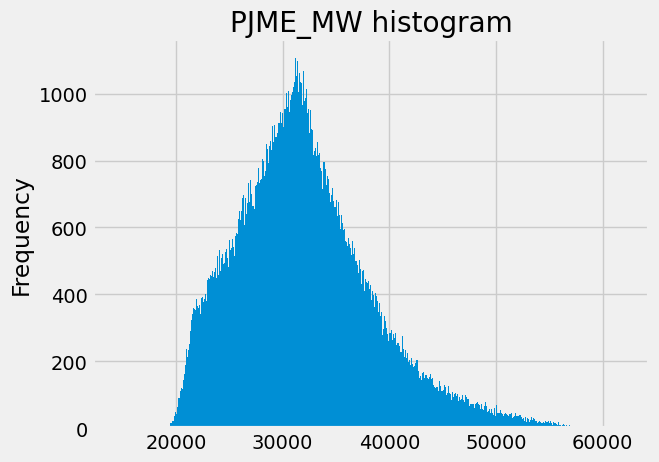

In [6]:
df["PJME_MW"].plot(kind='hist', bins = 500, title='PJME_MW histogram')

<Axes: title={'center': 'PJME_MW < 20000'}, xlabel='Datetime'>

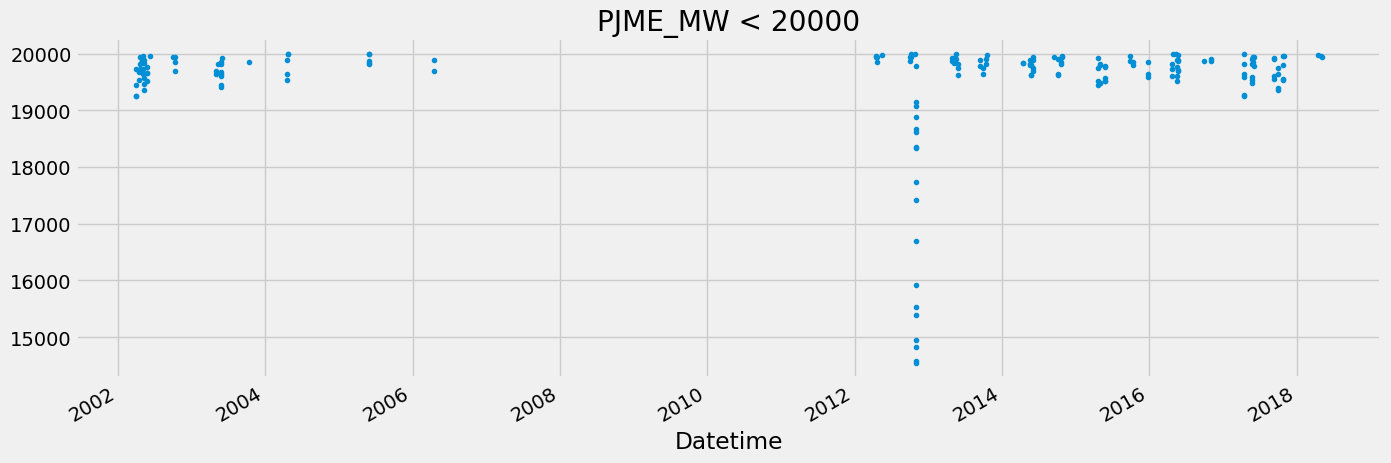

In [7]:
df.query('PJME_MW < 20000')["PJME_MW"].plot(figsize=(15, 5), title='PJME_MW < 20000', style='.')

### outlier removal using z-score

#### bad idea, wanted to try it!

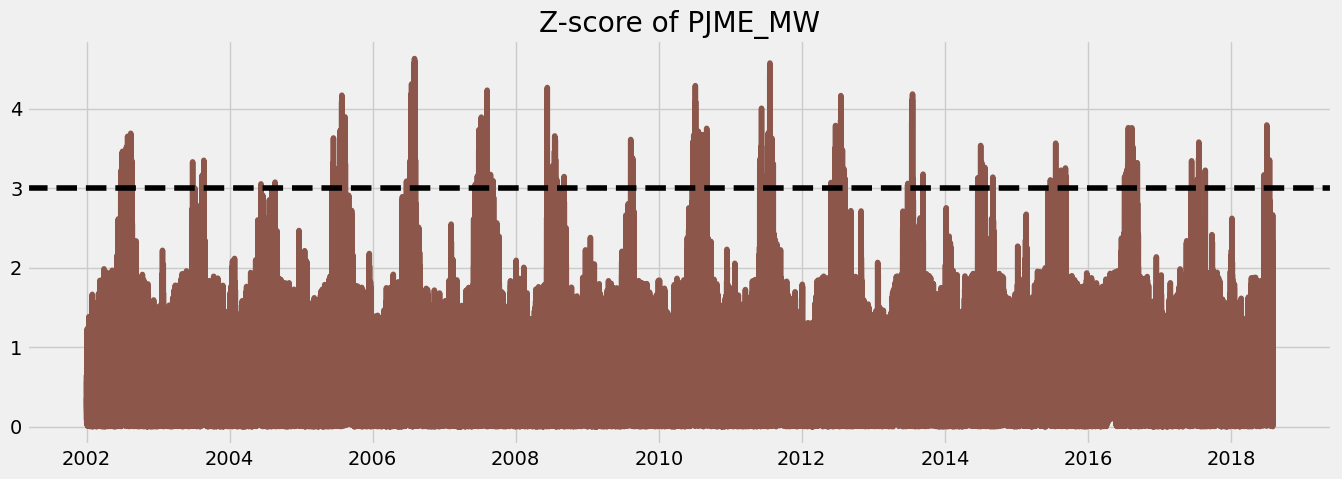

In [8]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df['PJME_MW']))
# plot the z-scores
plt.figure(figsize=(15, 5))
plt.plot(z, color=color_pal[5])
plt.axhline(3, color='black', linestyle='--')
plt.title('Z-score of PJME_MW')
plt.show()

# not helpful because the abs mix them up

## outlier removal using IQR

Lower bound: 19334.46
Upper bound: 43807.770000000004


<Axes: title={'center': 'PJME_MW outliers'}, xlabel='Datetime'>

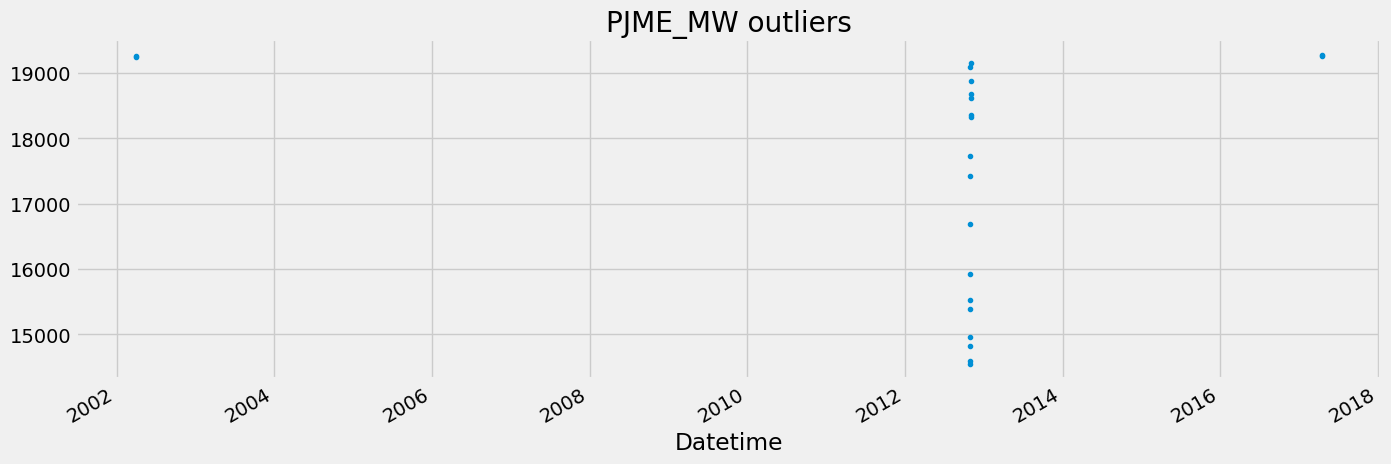

In [9]:
Q1 = df['PJME_MW'].quantile(0.25)
Q3 = df['PJME_MW'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.02 * IQR
upper_bound = Q3 + 1.01 * IQR
print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

df.query('PJME_MW < @lower_bound')["PJME_MW"].plot(figsize=(15, 5), title='PJME_MW outliers', style='.')

In [10]:
df = df.query('PJME_MW > @lower_bound').copy()

# Train / Test Split

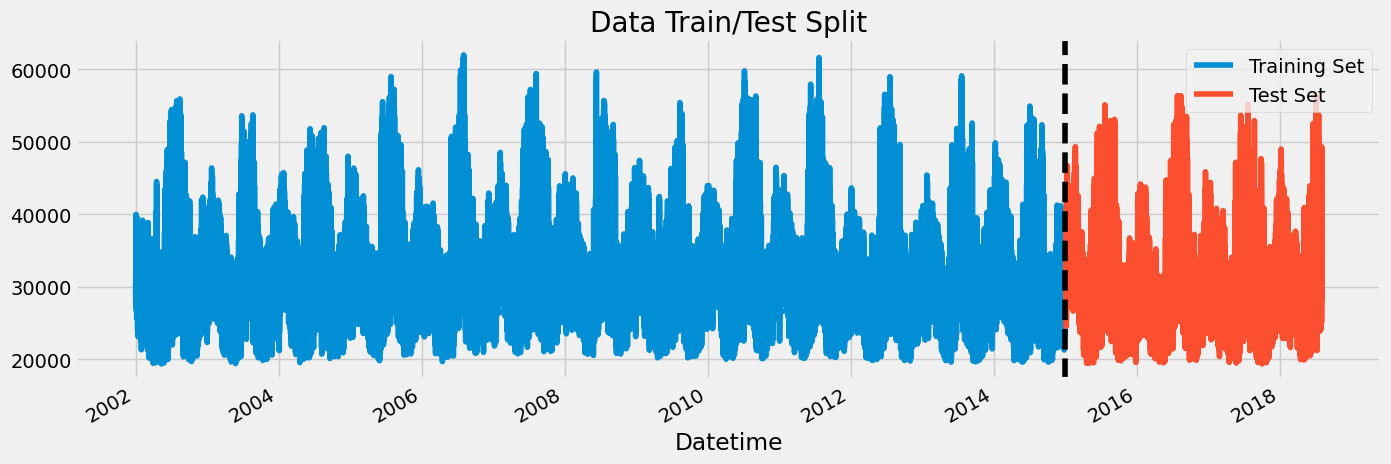

In [11]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.Timestamp('01-01-2015'), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Timeseries cross validation

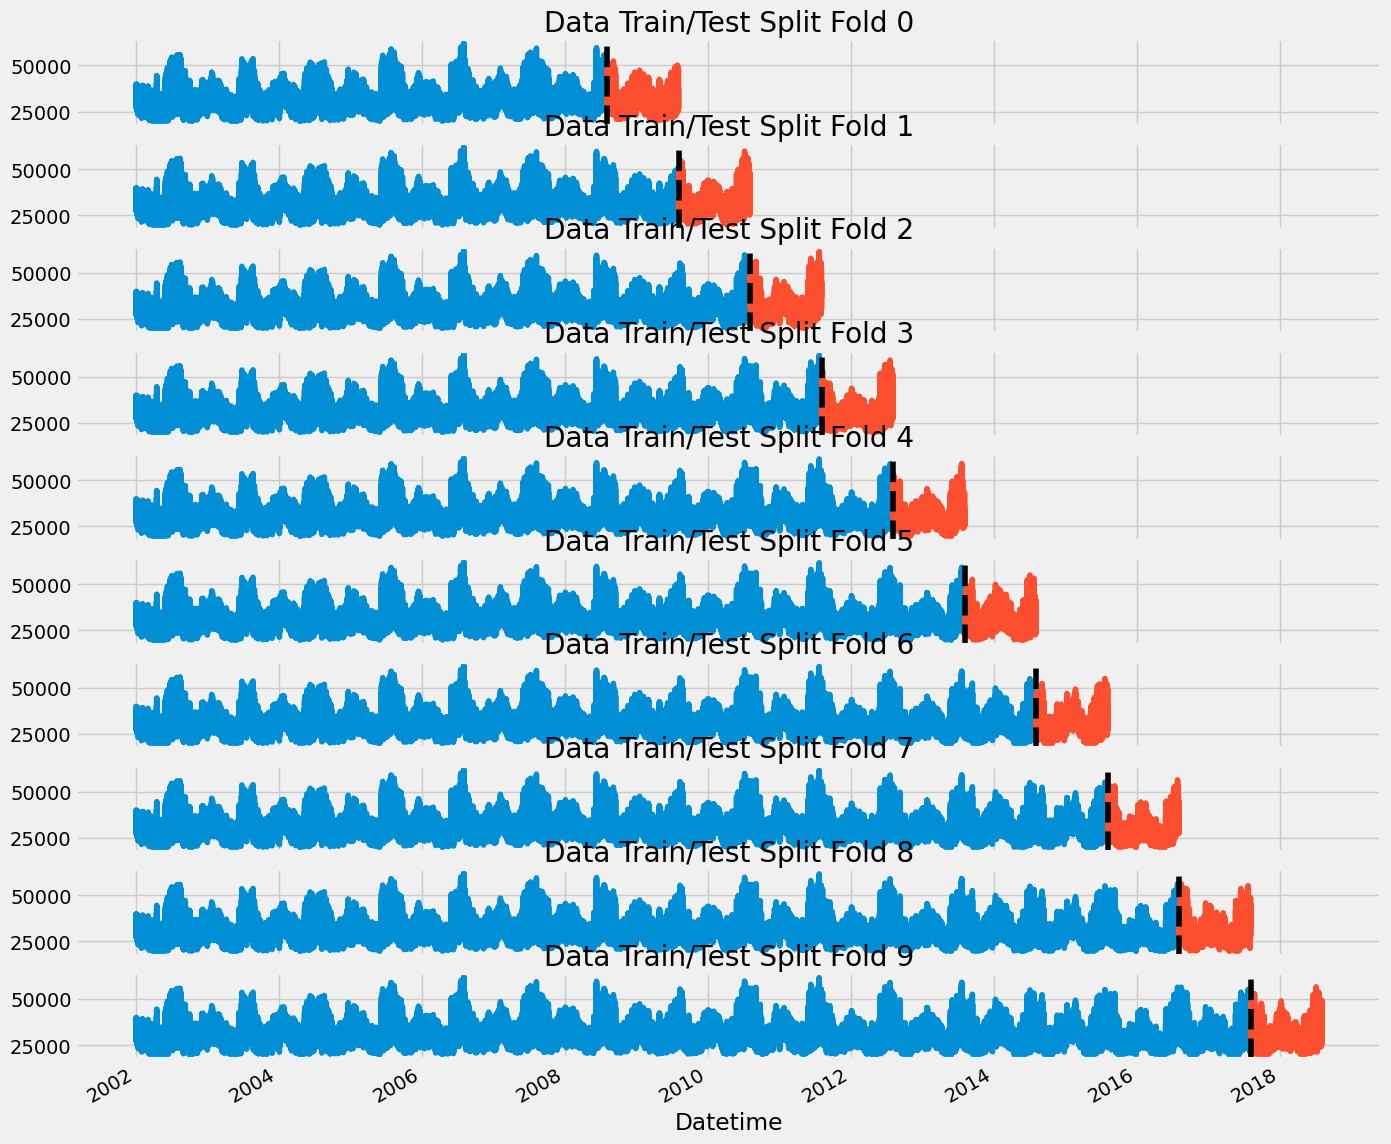

In [12]:
from sklearn.model_selection import TimeSeriesSplit
# test set is 1 year
# gap is 1 day between train and test
tss = TimeSeriesSplit(n_splits=10, test_size= 24*365*1, gap=24)
df = df.sort_index()
fig, axs = plt.subplots(10,1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    train['PJME_MW'].plot(ax=axs[fold], 
                          label = 'Training Set',
                          title='Data Train/Test Split Fold {}'.format(fold))
    test['PJME_MW'].plot(ax=axs[fold], label = 'Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    
    
    fold += 1

## Forecasting Horizon Explained
1. The forecat horizon is the number of time steps into the future that we are asked to forecast.
2. These generally range from less then 3 months to more than 2 years 

## Lag Feautures

In [13]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    """
    takes the dataframe and adds lags for the last 3 years
    returns the dataframe with the new columns
    """ 
    target_map = df['PJME_MW'].to_dict()
    df['lag1Year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2Year'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3Year'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)


# Feature Creation

In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# df = create_features(df)

# Visualize our Feature / Target Relationship

In [15]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.boxplot(data=df, x='hour', y='PJME_MW')
# ax.set_title('MW by Hour')
# plt.show()

In [14]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
# ax.set_title('MW by Month')
# plt.show()

## Train using cross validation

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np


# Time series split
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# Prepare data
df = df.sort_index()

# Splitting and training
fold = 0
preds = []
scores = []

for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1Year', 'lag2Year', 'lag3Year']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Initialize model
    reg = xgb.XGBRegressor(objective='reg:linear', learning_rate=0.01, n_estimators=1000,
                           max_depth=3, early_stopping_rounds=50, base_score=0.5)

    # Fit the best model on the full training data
    reg.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=1000)

    # Predict and evaluate
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

# Output the results
print("Scores:", scores)
print("Average score:", np.mean(scores))



[0]	validation_0-rmse:32732.80904	validation_1-rmse:31957.13799
[446]	validation_0-rmse:3364.55033	validation_1-rmse:3764.69692
[0]	validation_0-rmse:32672.61199	validation_1-rmse:32136.85600
[999]	validation_0-rmse:3169.85168	validation_1-rmse:3418.56178
[0]	validation_0-rmse:32631.53900	validation_1-rmse:31074.57172
[406]	validation_0-rmse:3482.42247	validation_1-rmse:3496.90277
[0]	validation_0-rmse:32528.74090	validation_1-rmse:31478.17213
[842]	validation_0-rmse:3239.87299	validation_1-rmse:4085.36289
[0]	validation_0-rmse:32462.52434	validation_1-rmse:31463.88896
[438]	validation_0-rmse:3482.57767	validation_1-rmse:4008.64282
Scores: [3760.2984185992054, 3418.5617857307807, 3475.0719723326097, 4083.936954205504, 3999.7342790608204]
Average score: 3747.520681985784


# Predicting the future

In [17]:
df = create_features(df)
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1Year', 'lag2Year', 'lag3Year']
TARGET = 'PJME_MW'

x_all = df[FEATURES]
y_all = df[TARGET]

In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(x_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32404.06249
[100]	validation_0-rmse:12417.51354
[200]	validation_0-rmse:5743.52208
[300]	validation_0-rmse:3965.52618
[400]	validation_0-rmse:3569.13711
[499]	validation_0-rmse:3467.25173


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [19]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [20]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='H')
future_df = pd.DataFrame(index=future)
future_df['isfuture'] = True
df['isfuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = add_lags(df_and_future)
df_and_future = create_features(df_and_future)

In [21]:
future_w_futures = df_and_future.query('isfuture').copy()
future_w_futures

PJME_MW  lag1Year  lag2Year  lag3Year  hour  dayofweek  \
2018-08-03 00:00:00      NaN   33539.0   32094.0   31695.0     0          4   
2018-08-03 01:00:00      NaN   30781.0   29503.0   29128.0     1          4   
2018-08-03 02:00:00      NaN   29015.0   27712.0   27373.0     2          4   
2018-08-03 03:00:00      NaN   27884.0   26535.0   26233.0     3          4   
2018-08-03 04:00:00      NaN   27223.0   25870.0   25643.0     4          4   
...                      ...       ...       ...       ...   ...        ...   
2019-07-31 20:00:00      NaN   46912.0   39352.0   40243.0    20          2   
2019-07-31 21:00:00      NaN   45985.0   38699.0   39183.0    21          2   
2019-07-31 22:00:00      NaN   44094.0   37346.0   37759.0    22          2   
2019-07-31 23:00:00      NaN   40666.0   34555.0   34641.0    23          2   
2019-08-01 00:00:00      NaN   37158.0   31646.0   31470.0     0          3   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2018-08-03 00:00:00        3      8  2018        215           3          31   
2018-08-03 01:00:00        3      8  2018        215           3          31   
2018-08-03 02:00:00        3      8  2018        215           3          31   
2018-08-03 03:00:00        3      8  2018        215           3          31   
2018-08-03 04:00:00        3      8  2018        215           3          31   
...                      ...    ...   ...        ...         ...         ...   
2019-07-31 20:00:00        3      7  2019        212          31          31   
2019-07-31 21:00:00        3      7  2019        212          31          31   
2019-07-31 22:00:00        3      7  2019        212          31          31   
2019-07-31 23:00:00        3      7  2019        212          31          31   
2019-08-01 00:00:00        3      8  2019        213           1          31   

                     isfuture  
2018-08-03 00:00:00      True  
2018-08-03 01:00:00      True  
2018-08-03 02:00:00      True  
2018-08-03 03:00:00      True  
2018-08-03 04:00:00      True  
...                       ...  
2019-07-31 20:00:00      True  
2019-07-31 21:00:00      True  
2019-07-31 22:00:00      True  
2019-07-31 23:00:00      True  
2019-08-01 00:00:00      True  

[8713 rows x 13 columns]

### predict the future

In [22]:
future_w_futures['preds'] = reg.predict(future_w_futures[FEATURES])


<Axes: title={'center': 'Predicted MW for 2018-2019'}>

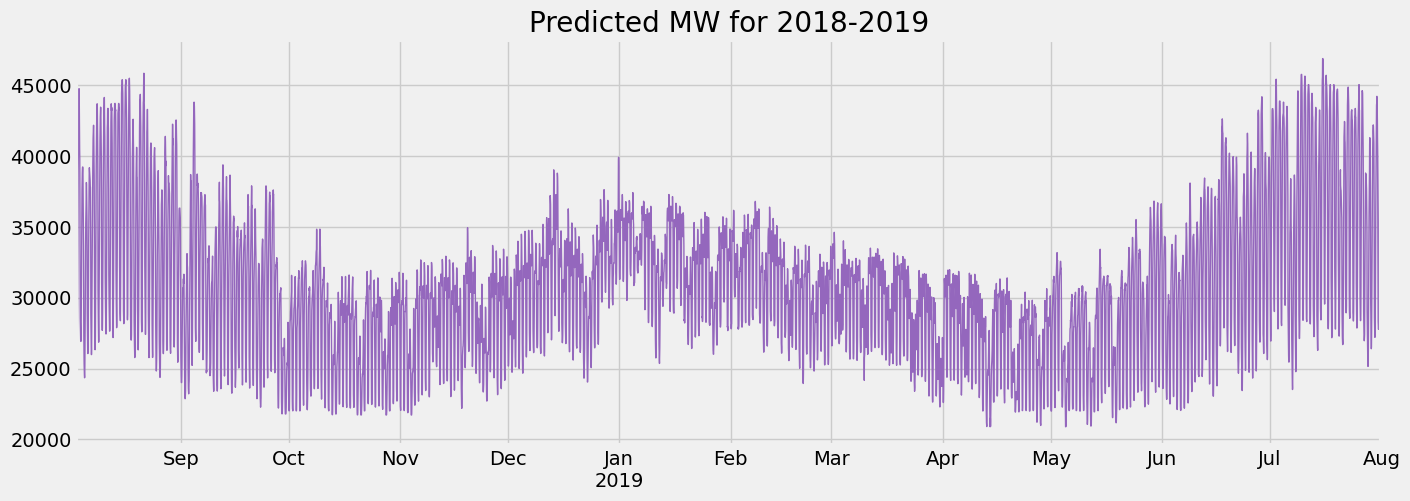

In [23]:
future_w_futures['preds'].plot(figsize=(15, 5), title='Predicted MW for 2018-2019',
                               ms = 1, lw=1, color=color_pal[4])

# Feature Importance
1. https://www.youtube.com/watch?v=C80SQe16Rao

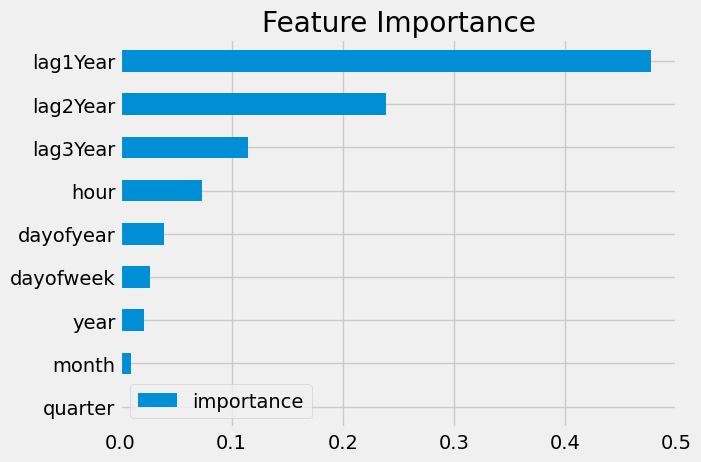

In [24]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Permuatation importance using eli5
1. after shuffeling when the error is high, it means that the feature is important 
2. if error is low then the fature is not important

In [25]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(reg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), show_feature_values = True)	

2024-09-16 07:54:38.687337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 07:54:38.687494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 07:54:38.860445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Partial Plots

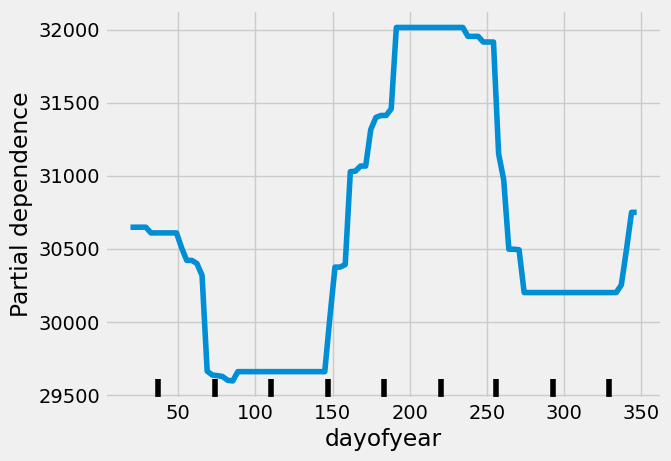

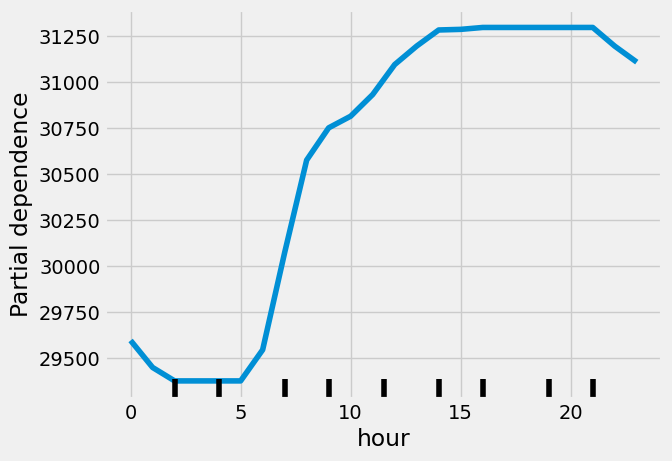

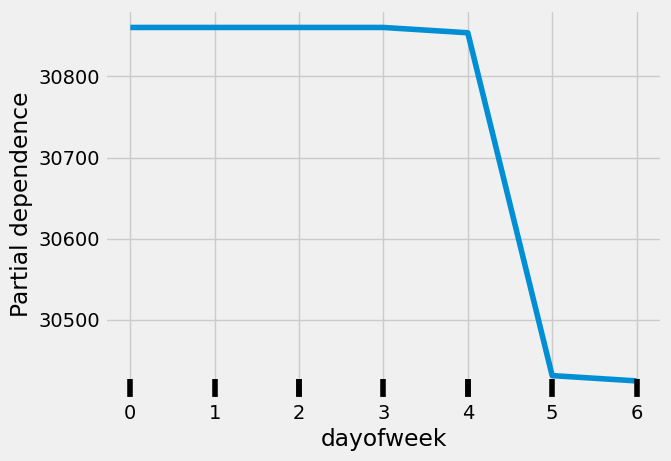

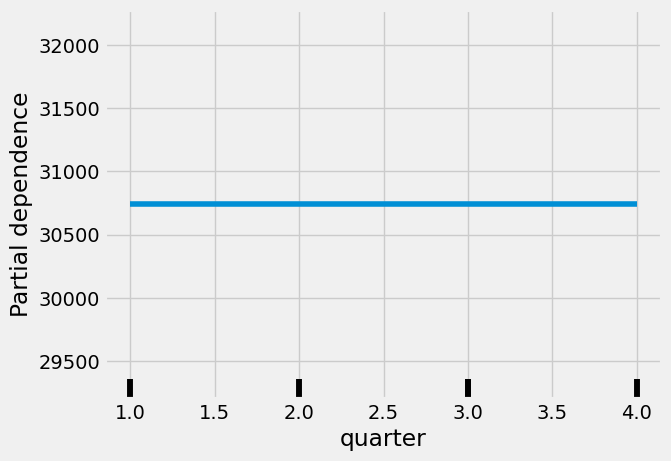

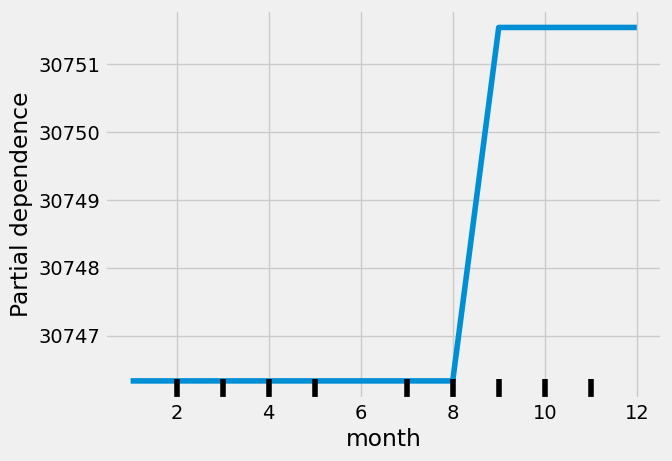

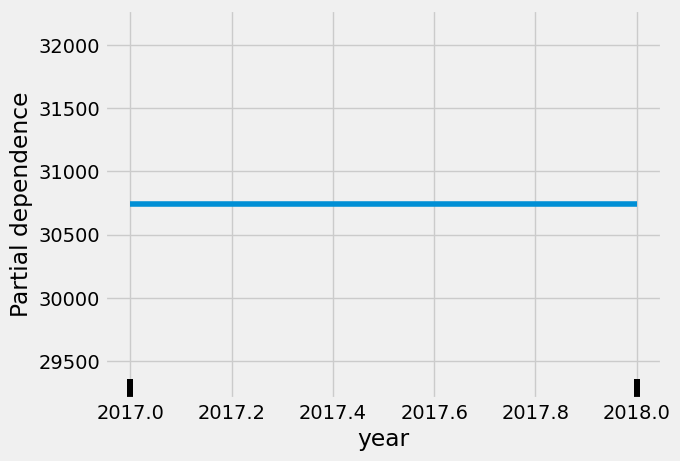

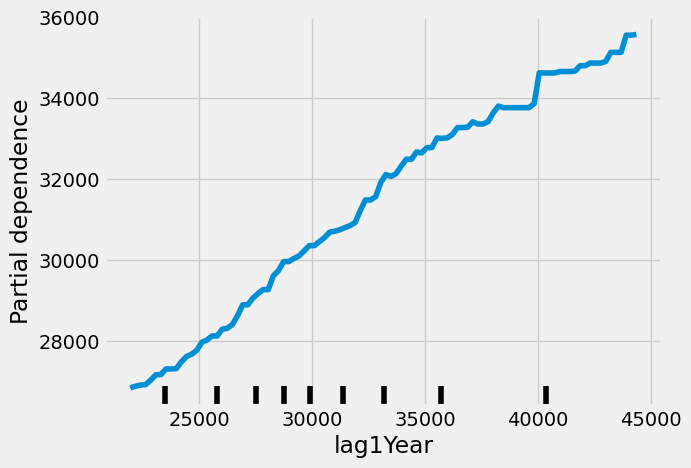

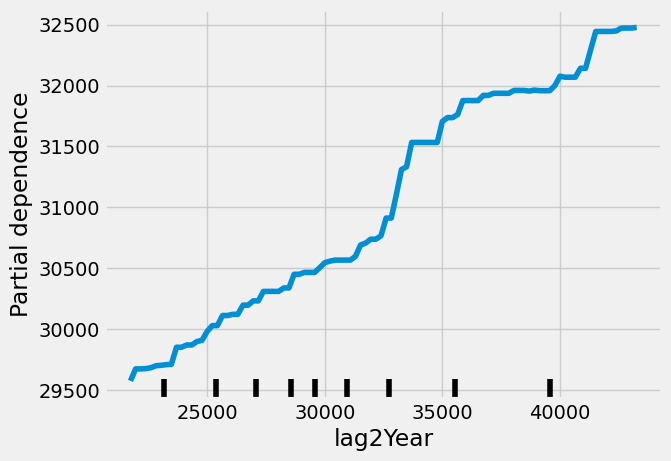

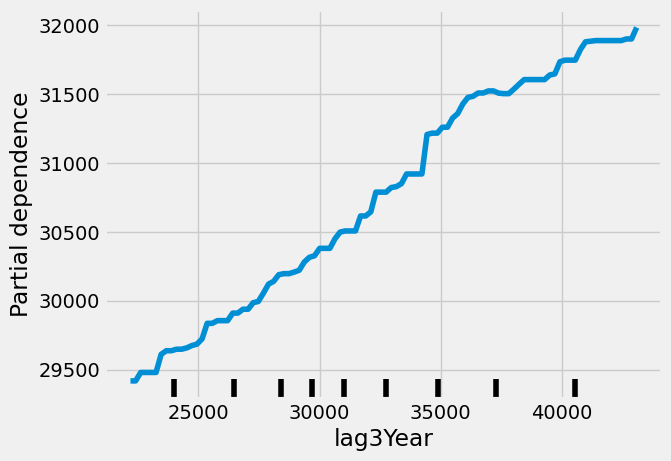

In [26]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
for col in X_test.columns:
    disp1 = PartialDependenceDisplay.from_estimator(reg, X_test, [col])
    plt.show()

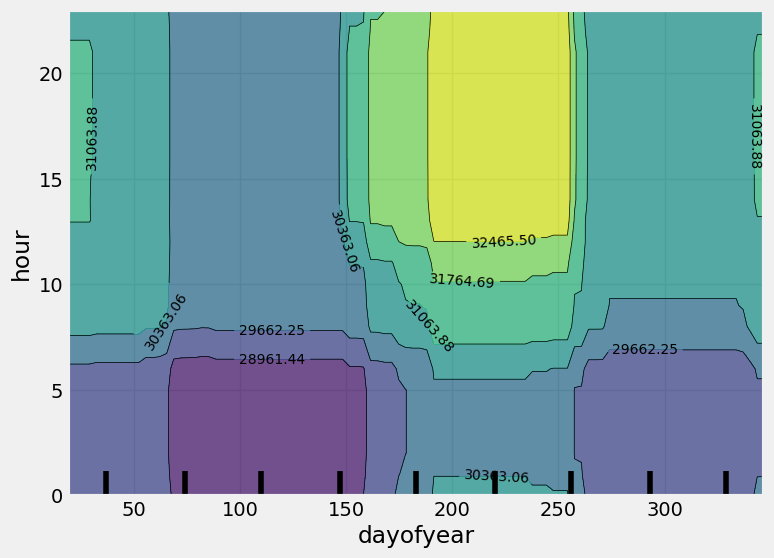

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('dayofyear', 'hour')]
# Similar to previous PDP plot except we use tuple of features instead of single feature
disp4 = PartialDependenceDisplay.from_estimator(reg, X_test, f_names, ax=ax)
plt.show()

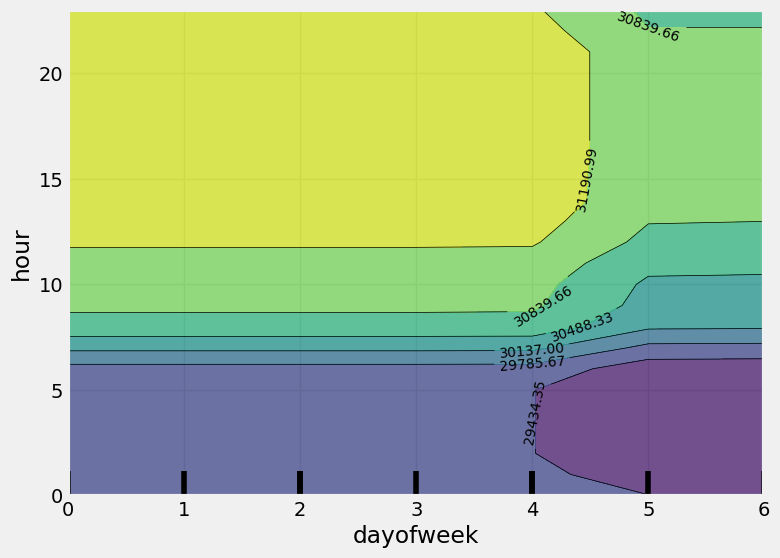

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('dayofweek', 'hour')]
# Similar to previous PDP plot except we use tuple of features instead of single feature
disp4 = PartialDependenceDisplay.from_estimator(reg, X_test, f_names, ax=ax)
plt.show()


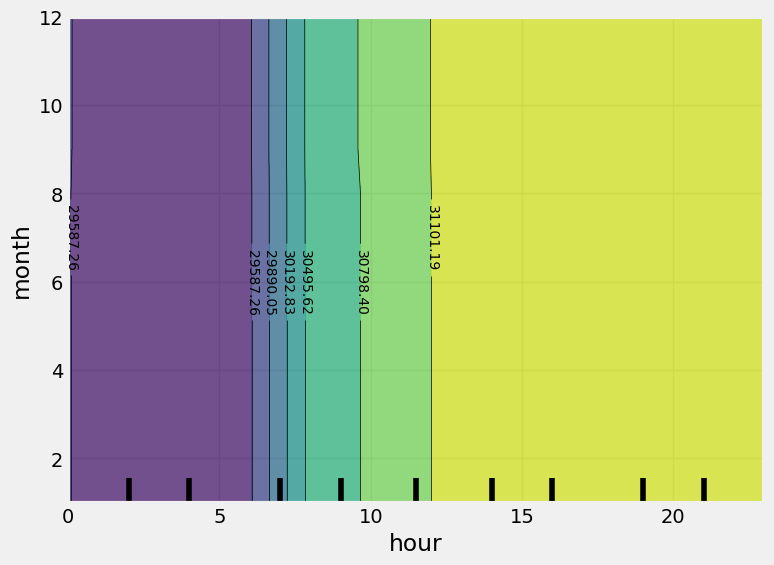

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('hour', 'month')]
# Similar to previous PDP plot except we use tuple of features instead of single feature
disp4 = PartialDependenceDisplay.from_estimator(reg, X_test, f_names, ax=ax)
plt.show()

## SHAP Values
1. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value

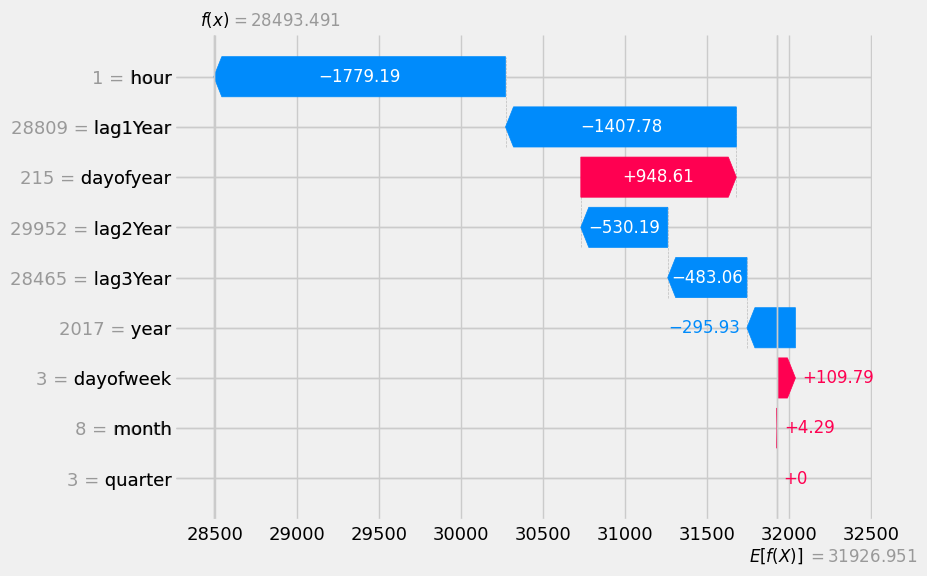

In [33]:
import shap
explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_test)

# waterfall plot
shap.plots.waterfall(shap_values[0])

In [34]:
import shap

shap.plots.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0:1000,:],X_test.iloc[0:1000,:])

AssertionError: Feature and SHAP matrices must have the same number of rows!

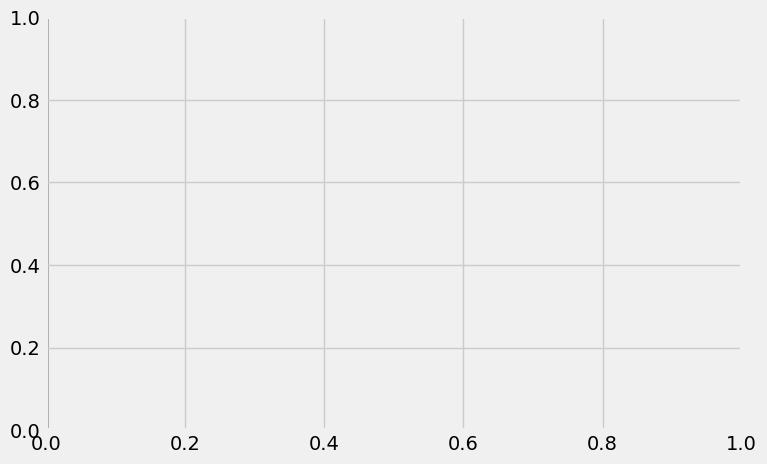

In [35]:
import shap
shap.summary_plot(shap_values, X_train)

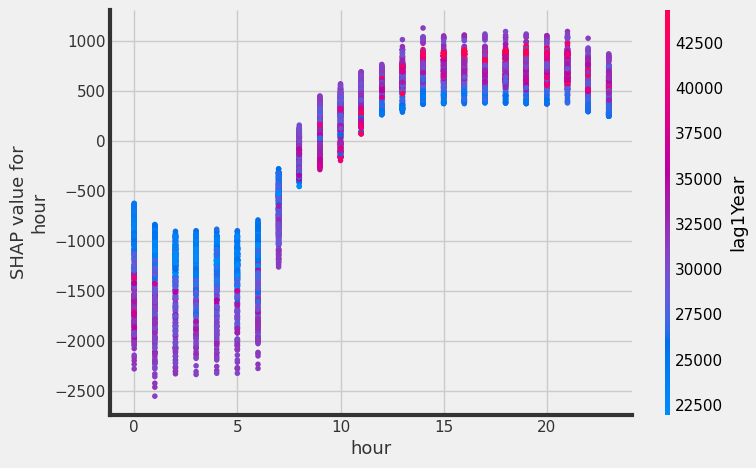

In [36]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)
shap.dependence_plot('hour', shap_values, X_test)

In [37]:
explainer = shap.Explainer(reg, X_test)
shap_values = explainer(X_test)
shap.plots.heatmap(shap_values[0])

100%|===================| 8751/8760 [01:07<00:00]        

DimensionError: The hclust order only supports 2D arrays right now!

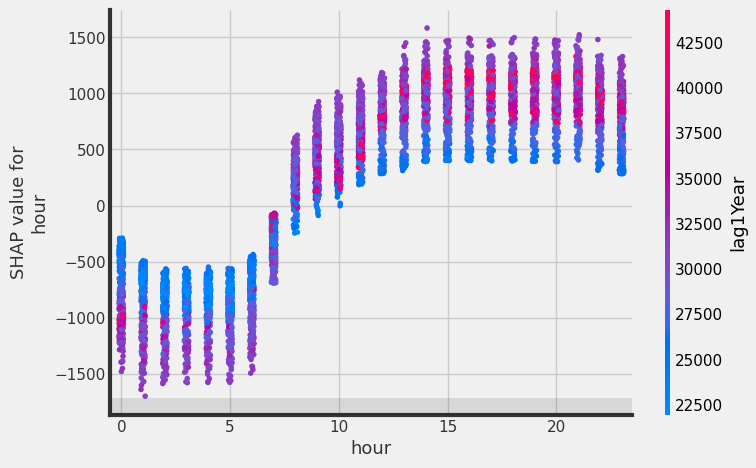

In [38]:
shap.plots.scatter(shap_values[:, "hour"], color=shap_values)

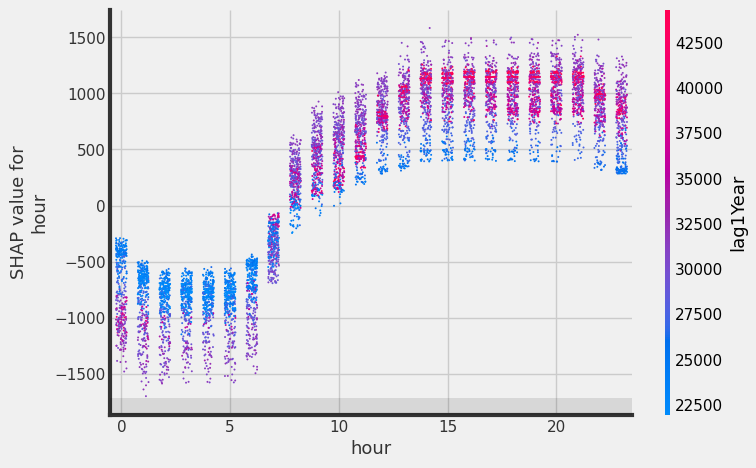

In [39]:
shap.plots.scatter(shap_values[:,"hour"], dot_size=2, x_jitter=0.5, color=shap_values)

# Saving model for later 

In [40]:
reg.save_model('energy_consumption_model.json')

In [41]:
#list working directory
import os
print(os.listdir(os.getcwd()))
#file größe
print(os.path.getsize('energy_consumption_model.json'))

['.virtual_documents', 'energy_consumption_model.json']
571757


<Axes: title={'center': 'Predicted MW for 2018-2019'}>

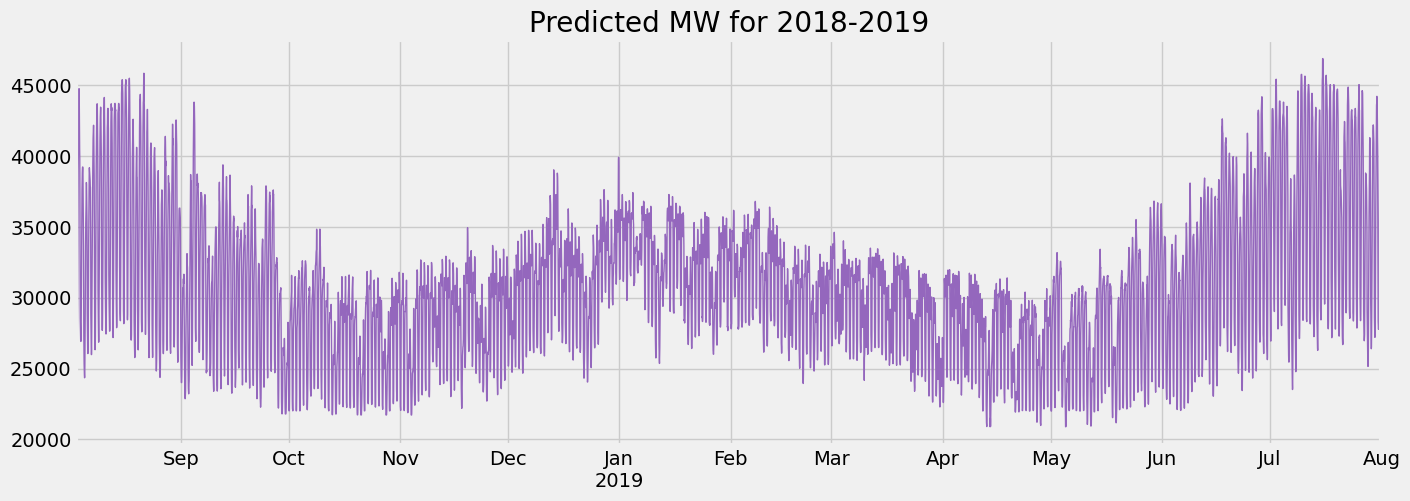

In [42]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('energy_consumption_model.json')
future_w_futures['preds'] = reg_new.predict(future_w_futures[FEATURES])
future_w_futures['preds'].plot(figsize=(15, 5), title='Predicted MW for 2018-2019',
                               ms = 1, lw=1, color=color_pal[4])